# Image stitching using Homography

In [ ]:
## Import necessary libraries here (You can add libraries you want to use here)
import os
import random
import cv2
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

<img src="https://drive.google.com/uc?id=1uOI8rpqb_FsR9Fi8GrGPZvICOcgflBj9&export=download" width="800"/>

## Overview

In this problem, we will implement an algorithm for automatically estimating the Homography Matrix using RANSAC and the normalized 8-point algorithm. 

Image Stitching Algorithm Overview
1. Detect keypoints
2. Match keypoints
3. Estimate homography with matched keypoints (using RANSAC)
4. Combine images

## Data

**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
!unzip "/content/hill.zip" -d "/content/hill"

!gdown 1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
!unzip "/content/tv.zip" -d "/content/tv"


Downloading...
From: https://drive.google.com/uc?id=1fnD0hJ8-_Rngsc-m96ghKtdZAMf0VTjy
To: /content/hill.zip
100% 205k/205k [00:00<00:00, 83.7MB/s]
Archive:  /content/hill.zip
  inflating: /content/hill/1.JPG     
  inflating: /content/hill/2.JPG     
  inflating: /content/hill/3.JPG     
Downloading...
From: https://drive.google.com/uc?id=1v2BFVMV0McuD5BstLvDmo1U9MrFAByS5
To: /content/tv.zip
100% 130k/130k [00:00<00:00, 68.6MB/s]
Archive:  /content/tv.zip
  inflating: /content/tv/1.jpg       
  inflating: /content/tv/2.jpg       
  inflating: /content/tv/3.jpg       


## Helper Functions

In [ ]:
import cv2

def drawMatches(image1, kp1, image2, kp2, idx_pairs):
    keypt1 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp1.tolist()]
    keypt2 = [cv2.KeyPoint(coord[1], coord[0], 40) for coord in kp2.tolist()]
    matches = [cv2.DMatch(pair[0], pair[1], 0) for pair in idx_pairs.tolist()]
    return cv2.drawMatches(image1, keypt1, image2, keypt2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

def plot_matches(images, feature_coord, matches, img_idx):
    matched_img = drawMatches(images[img_idx], feature_coord[img_idx], images[img_idx-1], 
                              feature_coord[img_idx-1], matches[img_idx-1])

    cv2.imshow('Matches Found', matched_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def est_homography(src, dest):
    N = src.shape[0]
    if N != dest.shape[0]:
        raise ValueError("src and diff should have the same dimension")
    src_h = np.hstack((src, np.ones((N, 1))))
    A = np.array([np.block([[src_h[n], np.zeros(3), -dest[n, 0] * src_h[n]],
                            [np.zeros(3), src_h[n], -dest[n, 1] * src_h[n]]])
                  for n in range(N)]).reshape(2 * N, 9)
    [_, _, V] = np.linalg.svd(A)
    return V.T[:, 8].reshape(3, 3)

def apply_homography(H, src):
    src_h = np.hstack((src, np.ones((src.shape[0], 1))))
    dest =  src_h @ H.T
    return (dest / dest[:,[2]])[:,0:2]

### Code

Loading data

In [ ]:
im_hill = []
im_tv = []

for i in range(3):
  im_hill.append(cv2.imread("/content/hill/" + str(i+1) + ".JPG"))
  im_tv.append(cv2.imread("/content/tv/" + str(i+1) + ".jpg"))

Helper functions to get matching points

In [ ]:
# YOUR CODE HERE: 

def detectKeypoints(img):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(img,None)
  return keypoints, descriptors

def getCoordinates(kp):
  coord = np.ones((len(kp),3))
  for i in range(len(kp)):
    coord[i,0] = kp[i].pt[0]
    coord[i,1] = kp[i].pt[1]
  return coord

def getMatches(img1, img2):
  kp1, dp1 = detectKeypoints(img1)
  kp2, dp2 = detectKeypoints(img2)

  coord1 = getCoordinates(kp1)
  coord2 = getCoordinates(kp2)

  matches = []

  # DR_thresh = 0.2
  DR_thresh = 0.4

  mode = "DR"

  for i in range(dp1.shape[0]):
    temp = dp1[i,:]
    norm = dp2.copy()

    for j in range(norm.shape[0]):  
      norm[j,:] = norm[j,:] - temp

    norm = np.linalg.norm(norm, axis=1)

    if mode == "DR":
      sorted_norm = np.sort(norm)
      DR = sorted_norm[0]/sorted_norm[1]
      if DR<DR_thresh:
        arg = np.argmin(norm)
        matches.append([int(i),int(arg)])

  matches = np.array(matches)

  coord_matches1 = coord1[matches[:,0]]
  coord_matches2 = coord2[matches[:,1]]

  return coord_matches1, coord_matches2


Helper functions to get Homography using RANSAC

In [ ]:
def errorH(coord1, coord2, H):
  # Function: Computing the Homography transformation error
  error = 0
  for i in range(coord1.shape[0]):
    transformed = H @ coord1[i,:].T
    transformed = transformed/transformed[2]
    error = error + np.linalg.norm(coord2[i,:].T - transformed , axis = 0)
  return error/coord1.shape[0]

def computeH(x1, y1, x2, y2):
  #  Function: compute Homographic matrix from corresponding points
  # YOUR CODE HERE: 

  H = np.zeros((x1.shape[0]*2,9))

  for i in range(x1.shape[0]):
    x = x1[i]
    x_ = x2[i]
    y = y1[i]
    y_ = y2[i]
    H[i*2:i*2 + 2,:] = np.array([[-x, -y, -1, 0, 0, 0, x*x_, y*x_, x_],
                                [0, 0, 0, -x, -y, -1, x*y_, y*y_, y_]])
    
  # SVD solution
  _ , _ , V = np.linalg.svd(H)
  h = V.T[:,8]
  H = np.reshape(h, (3,3))

  return H

def normalizeH(coordinates, matrix = False):
  # Function: find the transformation to make it zero mean and the variance as sqrt(2)
  # YOUR CODE HERE:
  og_coord = coordinates
  x = coordinates[:,0]
  y = coordinates[:,1]

  mean = (np.mean(x),np.mean(y))
  translate = np.array([[1,0,-mean[0]],
                        [0,1,-mean[1]],
                        [0,0,1]])
  
  coord = np.transpose(np.dot(translate, np.transpose(og_coord)))

  k_x = np.sqrt((x.shape[0])/(np.sum(coord[:,0]**2)))
  k_y = np.sqrt((y.shape[0])/(np.sum(coord[:,1]**2)))

  scaling = np.array([[k_x,0,0],
                      [0,k_y,0],
                      [0,0,1]])
  
  coord = np.transpose(np.dot(scaling, np.transpose(coord)))

  x_new = coord[:,0]
  y_new = coord[:,1]

  if matrix:
    T = np.dot(scaling, translate)
    return T
  
  else:
    return x_new, y_new

def denormalizeH(coord1, coord2, H):
  # Function: to reverse the normalization process and get the resultant homography
  T = normalizeH(coord1, matrix = True)
  T_ = normalizeH(coord2, matrix = True)
  H_denormalized = np.linalg.inv(T_) @ H @ T

  return H_denormalized

def getInliersH(pt1, pt2, H, thresh):
  # Function: implement the criteria checking inliers. 
  # YOUR CODE HERE:

  inliers = 0

  for i in range(pt1.shape[0]):
    transformed = H @ pt1[i,:].T
    transformed = transformed/transformed[2]
    score = np.linalg.norm(pt2[i,:].T - transformed)
    # print(score)
    if score < thresh:
      inliers = inliers + 1
    
  # print(inliers)

  return inliers
  
def ransacH(img1, img2, thresh = 0.02):
  # Find normalization matrix
  # Transform point set 1 and 2
  # RANSAC based 8-point algorithm
  # YOUR CODE HERE: 

  coord1, coord2 = getMatches(img1, img2)
  
  x1N, y1N = normalizeH(coord1)
  x2N, y2N = normalizeH(coord2)

  pt1 = np.ones((coord1.shape[0],3))
  pt2 = np.ones((coord2.shape[0],3))

  pt1[:,0] = x1N
  pt1[:,1] = y1N

  pt2[:,0] = x2N
  pt2[:,1] = y2N

  inliers = []
  H_bank = []

  for i in range(1000):
    rand = np.random.choice(coord1.shape[0], 4, replace=False)
    x1R = x1N[rand]
    y1R = y1N[rand]
    x2R = x2N[rand]
    y2R = y2N[rand]

    H = computeH(x1R, y1R, x2R, y2R)
    R1 = np.hstack((x1R,y1R)).reshape((4,2))
    R2 = np.hstack((x2R,y2R)).reshape((4,2))

    inliers.append(getInliersH(pt1, pt2, H, thresh))
    H_bank.append(H)

  best = np.argmax(np.array(inliers))
  H_best = H_bank[best]
  
  H_best = denormalizeH(coord1, coord2, H_best)

  return H_best

Function to get the stitched image

In [ ]:
def getStitchedImage(im_list):
  w = 0
  c_height = max([im.shape[0] for im in im_list])
  c_width = sum([im.shape[1] for im in im_list])
  canvas = np.uint8(np.zeros((3*c_height,c_width,3)))
  canvas[c_height:c_height*2,im_list[0].shape[1]:im_list[0].shape[1] + im_list[1].shape[1],:] = im_list[1]
  temp = im_list

  for i in [0,2]:
    H = ransacH(im_list[i],canvas)
    print("\nThe homography to transform image" + str(i+1) + " to image 2 is :\n")
    print(H)
    warped = cv2.warpPerspective(im_list[i], H,(c_width, 3*c_height))
    canvas[canvas == 0] = warped[canvas == 0]

  print("\nBefore trimming : \n")
  cv2_imshow(canvas)

  args = np.where(canvas!=0)
  trim1 = canvas[np.min(args[0]):np.max(args[0]), np.min(args[1]):np.max(args[1]), :]

  print("\nAfter trimming : \n")
  cv2_imshow(trim1)

  return canvas

### Write-up
*  How to remove incorrect matches with RANSAC?

Let X' and X be the matching points from the objective image and input image respectively.

We use RANSAC to sample 4 matching points and iteratively find different hypotheses with the selected points. We then evaluate every hypothesis by calculating the error metric X'-HX for every pair of matching points. X'-HX gives the normalized pixel distance between the transformed and the objective points. If the error metric for a pair of matching points is lesser than the threshold, it's an inlier, if not, it's an outlier. Finally we select the hypothesis which has the highest number of inliers.

Since we select the hypothesis which has the highest number of inliers, it means that the computed H is almost as close to what the real transformation between the two images could be. Hence if a pair of points which are tagged to be matches from a different algorithm, ends up being an outlier in the best hypothesis, we can comfortably say that these are incorrect matches or matches which aren't close to the precision we'd like to have. 


The homography to transform image1 to image 2 is :

[[ 6.53990735e-01 -5.54797415e-02  1.31854835e+02]
 [ 9.86689950e-02  5.45678656e-01  1.63724687e+02]
 [ 1.52598413e-04 -5.81790700e-05  5.43690694e-01]]

The homography to transform image3 to image 2 is :

[[ 4.69634922e-01  2.76836286e-02  3.17588774e+02]
 [-7.74863299e-02  5.92846294e-01  1.68609001e+02]
 [-1.63904191e-04  3.43828131e-05  5.93526098e-01]]

Before trimming : 



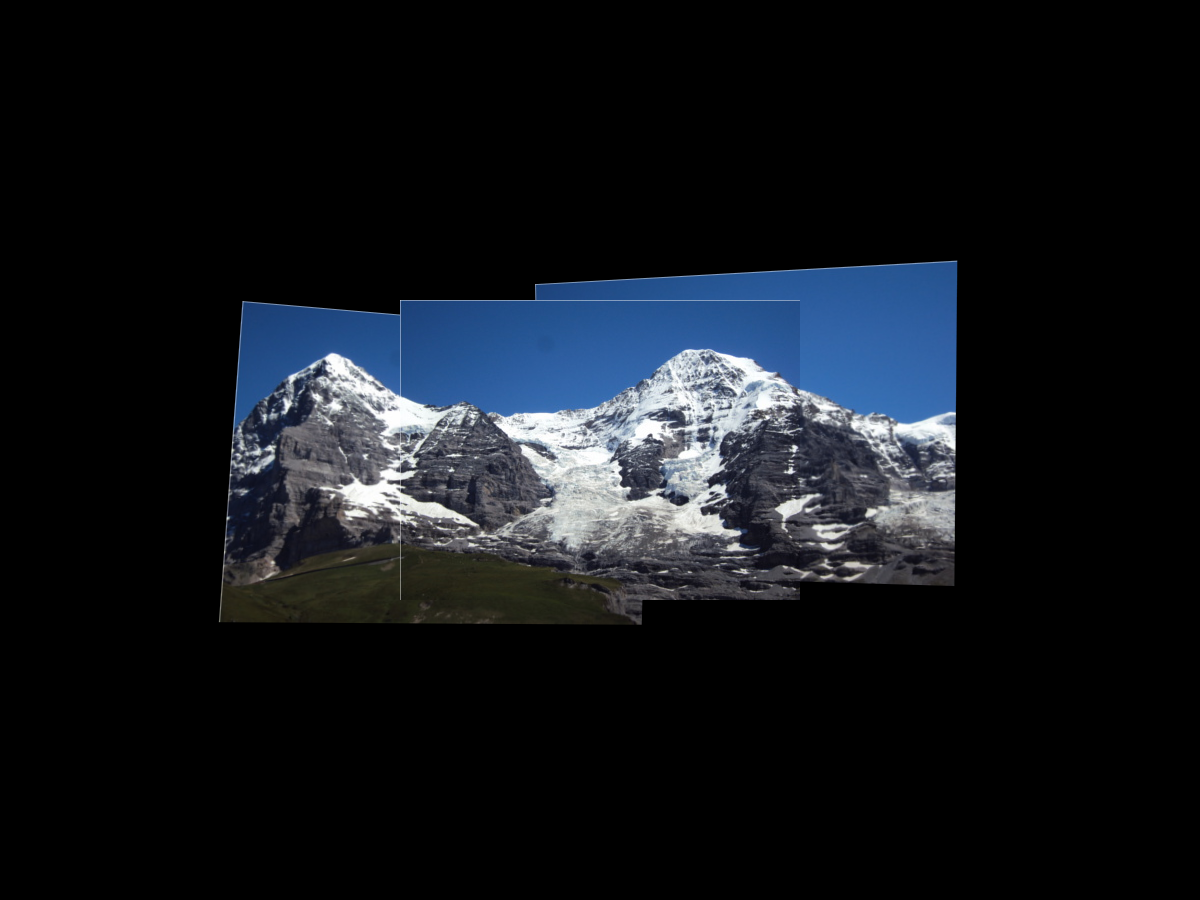


After trimming : 



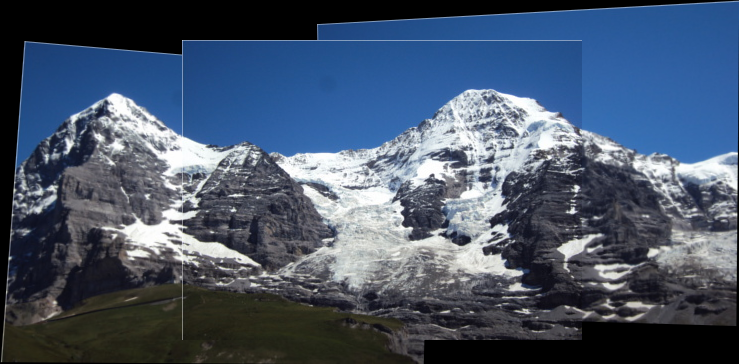

In [ ]:
canvas = getStitchedImage(im_hill)


The homography to transform image1 to image 2 is :

[[8.87876247e-01 1.60815863e-02 1.34841384e+01]
 [4.82871766e-01 5.91345292e-01 1.90543978e+02]
 [5.19466580e-04 1.44973434e-05 3.86650330e-01]]

The homography to transform image3 to image 2 is :

[[ 3.17593125e-01 -2.78138612e-02  4.32208363e+02]
 [-2.96724981e-01  5.50029177e-01  4.16153053e+02]
 [-3.19258618e-04 -2.44201401e-05  6.25714316e-01]]

Before trimming : 



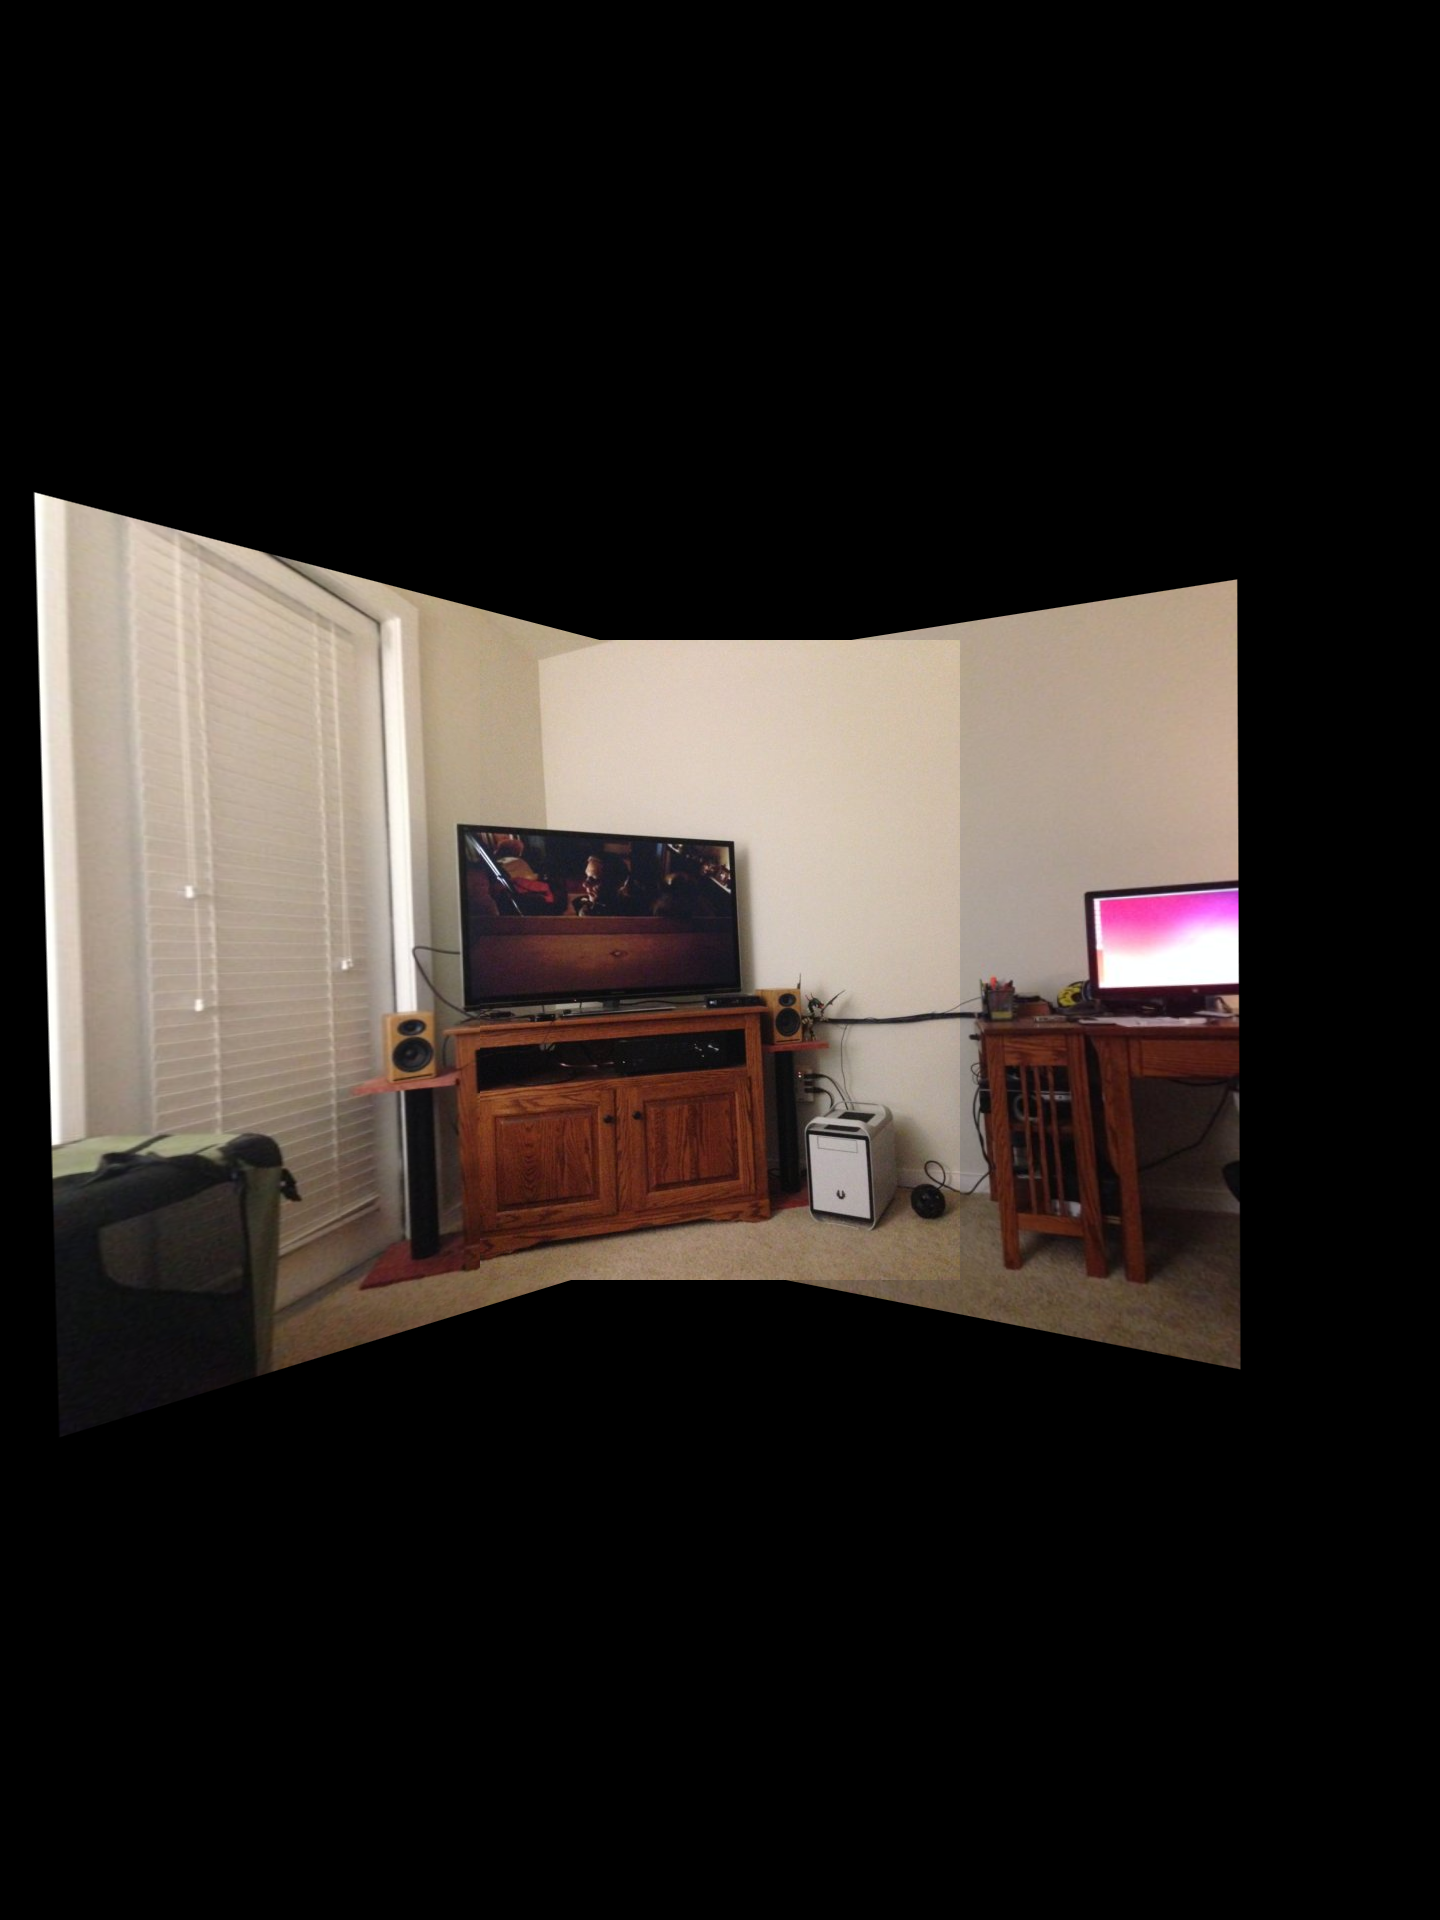


After trimming : 



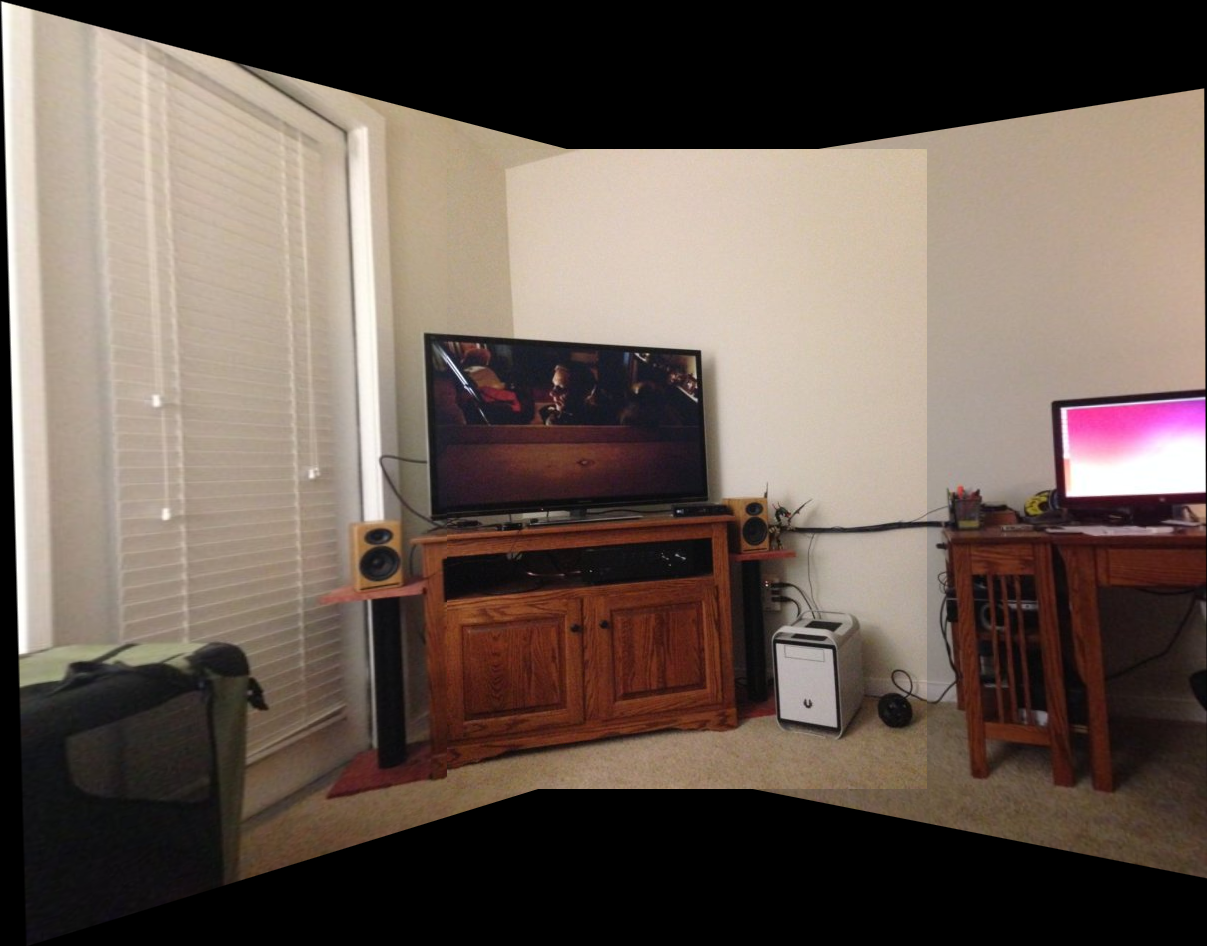

In [ ]:
canvas = getStitchedImage(im_tv)

The homography to transform image1 to image 2 is :

[[8.76686295e-01 1.21225640e-02 1.81291656e+01]

 [4.69041193e-01 5.83348762e-01 1.97115560e+02]
 
 [4.98486463e-04 6.03680354e-06 3.95806170e-01]]

The homography to transform image3 to image 2 is :

[[ 2.78268164e-01 -8.30397735e-03  4.31871769e+02]

 [-3.43679955e-01  5.69676932e-01  4.17461419e+02]

 [-3.64686194e-04 -5.46377063e-06  6.26923653e-01]]

Before trimming

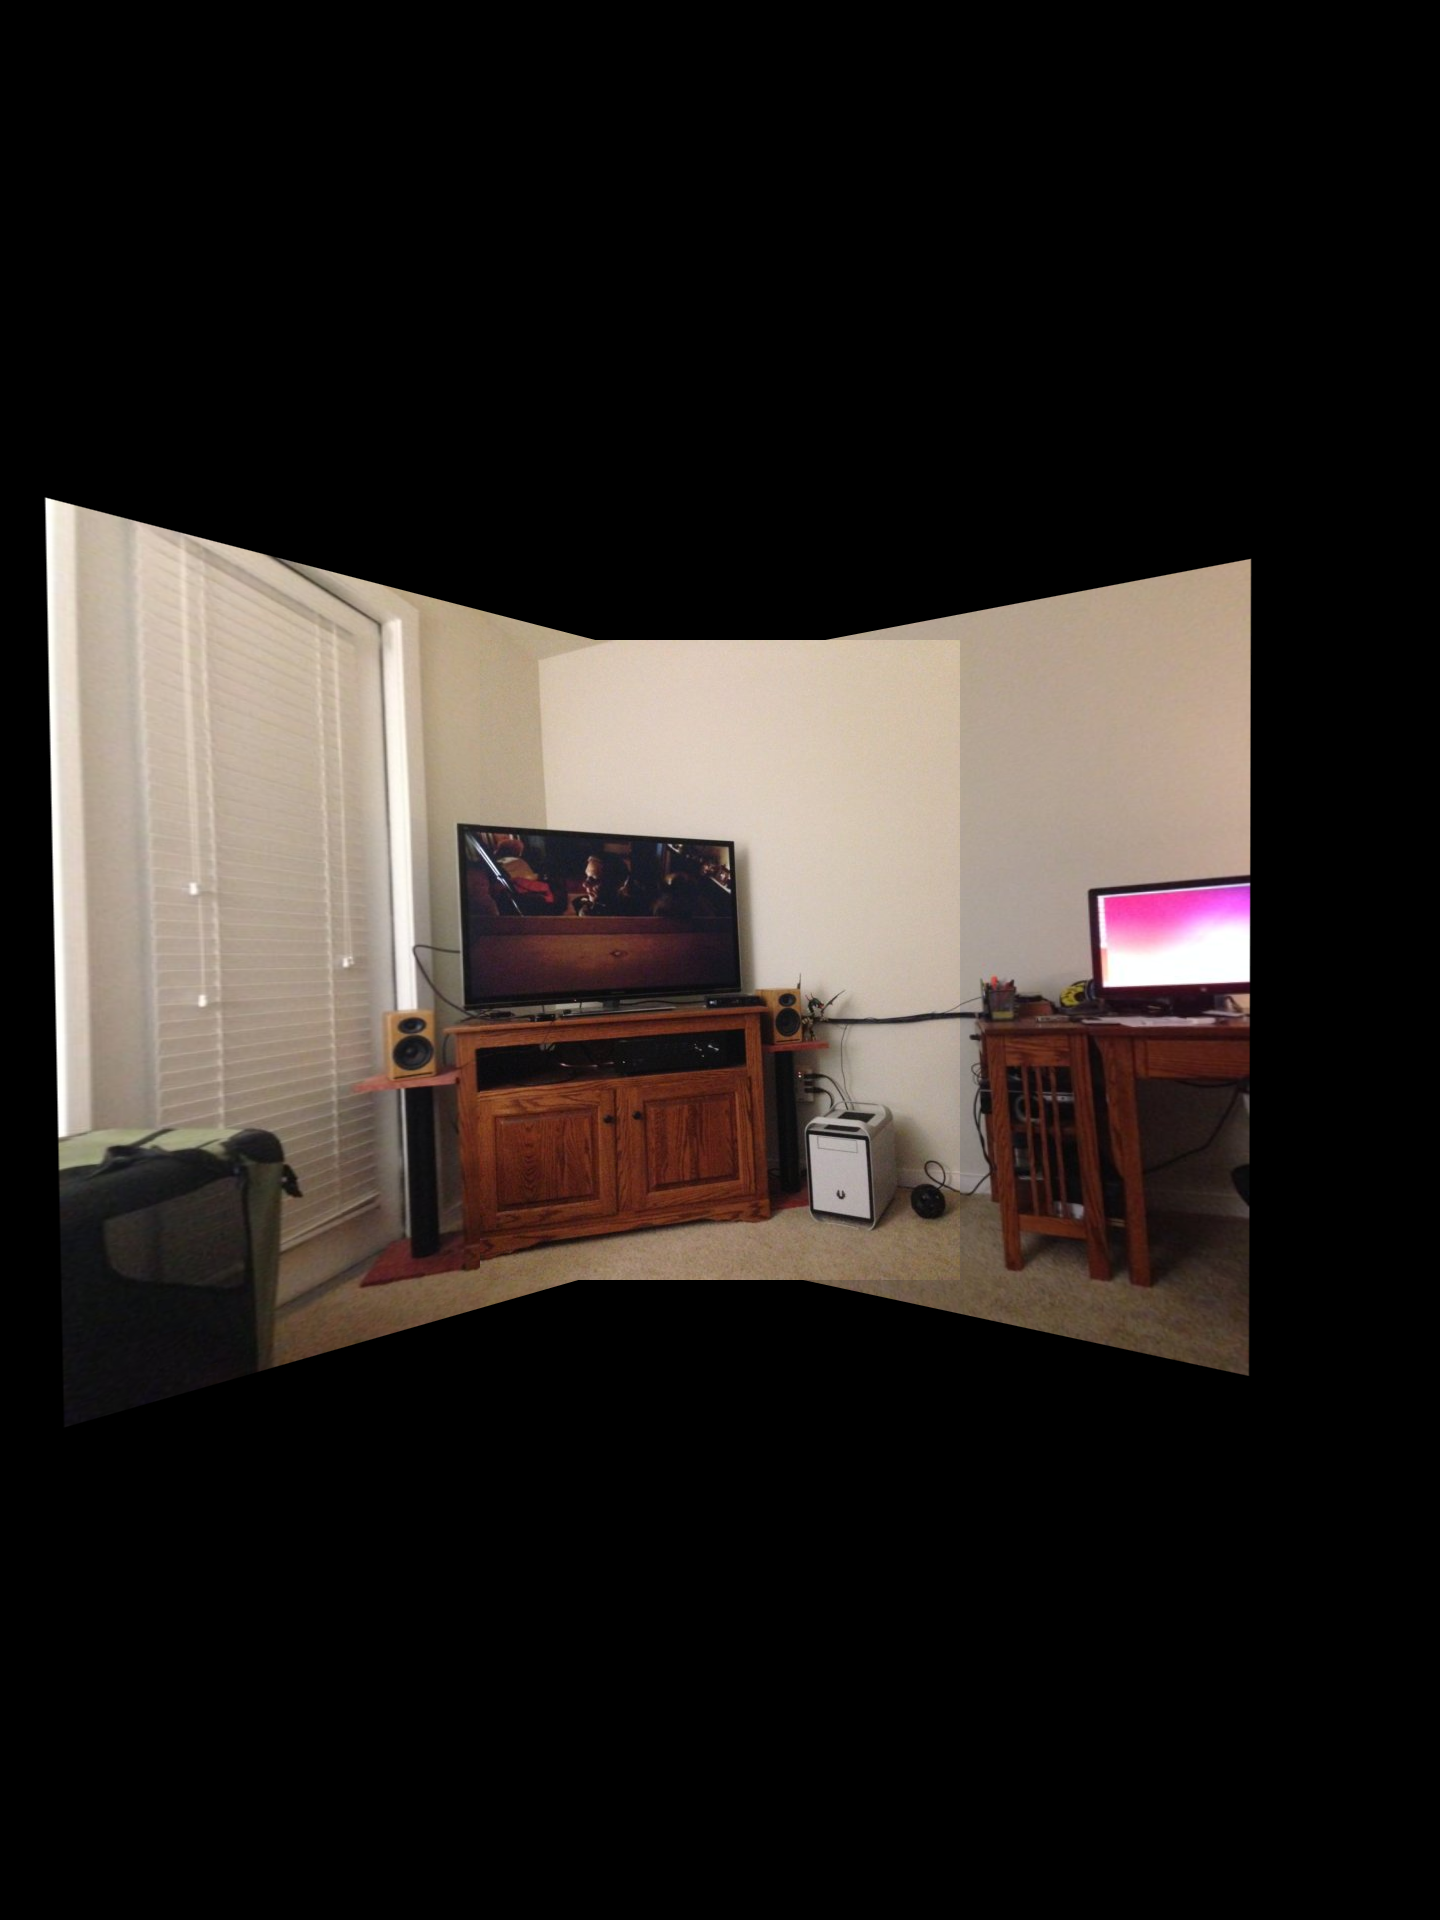

After trimming

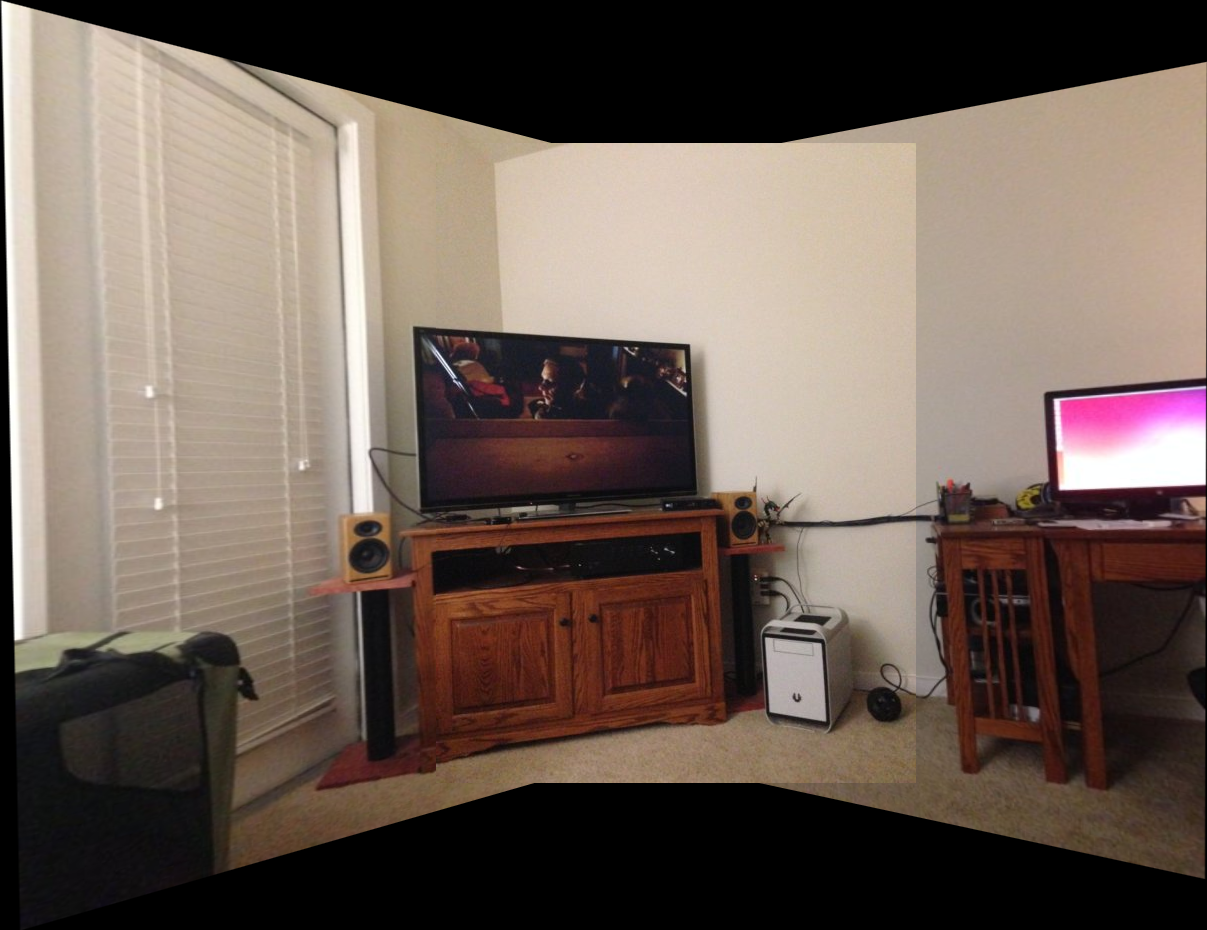